In [2]:
import numpy as np
from numpy import array
import pandas as pd
from pandas import concat
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import ParameterGrid
import logging
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import pickle
import matplotlib.image as mpimg

cutoff_train_test = 24

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred))) / np.mean(y_true) * 100

def is_cold(el):
    return (el.month > 10 or el.month < 3)

# add "is cold" and concatenate with another time series, if provided (for external regressors)
def prepare_time_series(df, original_df = None):
    df['is_cold'] = df['ds'].apply(is_cold)
    df['is_not_cold'] = ~df['ds'].apply(is_cold)
    if original_df is not None:
        original_df_restricted = original_df.loc[df.index.min():df.index.max(),:]
        return pd.concat([df, original_df_restricted], axis=1)
        
    return df

def make_single_df(prof, df_sales, df_external = None):
    if df_external is not None:
            df = pd.concat([df_sales, df_external], axis=1)
    else:
            df = df_sales
    df['ds'] = df.index
    df['y']=df['Sales']
    df = prepare_time_series(df)
    train_df = df[:-cutoff_train_test]

    future = prof.make_future_dataframe(periods=cutoff_train_test, freq = 'MS')
    future['Date'] = future['ds']
    future.set_index('Date', inplace=True)
    if df_external is not None:
            future = prepare_time_series(future, df[df_external.columns])
    else:
            future = prepare_time_series(future)

    forecast = prof.predict(future)
    forecast['Date'] = forecast['ds']
    forecast.set_index('Date', inplace=True)

    viz_df = train_df.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
    viz_df.loc[:,'y'] = df_sales.loc[:,'Sales']
    viz_df[df_external.columns] = df_external[df_external.columns]
    viz_df.loc[:,'ds'] = df_sales.index
    viz_df = prepare_time_series(viz_df)
    return viz_df

def make_df(prof,sarima, df_sales, df_external = None, name='CPI'):
    if df_external is not None:
            df = pd.concat([df_sales, df_external], axis=1)
    else:
            df = df_sales
    df['ds'] = df.index
    df['y']=df['Sales']
    df = prepare_time_series(df)
    train_df = df[:-cutoff_train_test]

    future = prof.make_future_dataframe(periods=cutoff_train_test, freq = 'MS')
    future['Date'] = future['ds']
    future.set_index('Date', inplace=True)
    if df_external is not None:
            future = prepare_time_series(future, df[df_external.columns])
    else:
            future = prepare_time_series(future)

    forecast = prof.predict(future)
    forecast['Date'] = forecast['ds']
    forecast.set_index('Date', inplace=True)
    pred = sarima.get_prediction(start=0, end=-1, exog=df_external[[name]][:-cutoff_train_test])
    fitted_values = pred.predicted_mean
    ci = pred.conf_int(alpha=0.05)
    ci.columns = ['sarima_lower', 'sarima_upper']

    fc = sarima.get_forecast(steps=cutoff_train_test, exog=df_external[[name]][-cutoff_train_test:])
    forecasted_values = fc.predicted_mean
    fcci = fc.conf_int(alpha=0.05)
    fcci.columns = ['sarima_lower', 'sarima_upper']
    ci = pd.concat([ci, fcci])
    ci['sarima_lower'][:12] = forecast[:12]['yhat_lower']
    ci['sarima_upper'][:12] = forecast[:12]['yhat_upper']
    fitted_values[:12] = forecast[:12]['yhat']


    forecast['sarima_pred'] = forecasted_values
    forecast['sarima_pred'] = forecast['sarima_pred'].fillna(fitted_values)
    forecast = pd.concat([forecast, ci], axis=1)

    viz_df = train_df.join(forecast[['yhat', 'yhat_lower','yhat_upper','sarima_pred','sarima_lower', 'sarima_upper']], how = 'outer')
    viz_df.loc[:,'y'] = df_sales.loc[:,'Sales']
    viz_df[df_external.columns] = df_external[df_external.columns]
    viz_df.loc[:,'ds'] = df_sales.index
    viz_df = prepare_time_series(viz_df)
    return viz_df

def make_prophet_df(prof1 ,prof2, df_sales, df_external = None):
    if df_external is not None:
            df = pd.concat([df_sales, df_external], axis=1)
    else:
            df = df_sales
    df['ds'] = df.index
    df['y']=df['Sales']
    df = prepare_time_series(df)
    train_df = df[:-cutoff_train_test]

    future = prof1.make_future_dataframe(periods=cutoff_train_test, freq = 'MS')
    future['Date'] = future['ds']
    future.set_index('Date', inplace=True)
    if df_external is not None:
            future = prepare_time_series(future, df[df_external.columns])
    else:
            future = prepare_time_series(future)

    forecast = prof1.predict(future)
    forecast['Date'] = forecast['ds']
    forecast.set_index('Date', inplace=True)
    forecast = forecast.rename(columns={'yhat' : 'yhat1','yhat_lower' : 'yhat1_lower', 'yhat_upper' : 'yhat1_upper'})

    future2 = prof2.make_future_dataframe(periods=cutoff_train_test, freq = 'MS')
    future2['Date'] = future2['ds']
    future2.set_index('Date', inplace=True)
    if df_external is not None:
            future2 = prepare_time_series(future2, df[df_external.columns])
    else:
            future2 = prepare_time_series(future2)

    forecast2 = prof2.predict(future2)
    forecast2['Date'] = forecast2['ds']
    forecast2.set_index('Date', inplace=True)
    forecast2 = forecast2.rename(columns={'yhat' : 'yhat2','yhat_lower' : 'yhat2_lower', 'yhat_upper' : 'yhat2_upper'})
    forecast = pd.concat([forecast, forecast2[['yhat2','yhat2_lower','yhat2_upper']]], axis=1)

    viz_df = train_df.join(forecast[['yhat1', 'yhat1_lower','yhat1_upper','yhat2','yhat2_lower', 'yhat2_upper']], how = 'outer')
    viz_df.loc[:,'y'] = df_sales.loc[:,'Sales']
    viz_df[df_external.columns] = df_external[df_external.columns]
    viz_df.loc[:,'ds'] = df_sales.index
    viz_df = prepare_time_series(viz_df)
    return viz_df

def plot_verif(verif, cutoff, ax, title=None, predcol='yhat',lower='yhat_lower', upper='yhat_upper'):
    train = verif[:-cutoff]
    ax.plot(train.index, train.y, 'ko', markersize=3)
    ax.plot(train.index, train[predcol], color='steelblue', lw=0.5)
    ax.fill_between(train.index, train[lower], train[upper], color='steelblue', alpha=0.3)
    test = verif[-cutoff-1:]
    ax.plot(test.index, test.y, 'ro', markersize=3)
    ax.plot(test.index, test[predcol], color='coral', lw=0.5)
    ax.fill_between(test.index, test[lower], test[upper], color='coral', alpha=0.3)
    ax.axvline(test.index.min(), color='0.8', alpha=0.7)
    ax.grid(ls=':', lw=0.5)
    if title is not None: 
        ax.set_title(title, fontsize=16)


def plot_joint_plot(verif, x='yhat', y='y', title=None,cutoff=cutoff_train_test, xlim=[0, 4e7], ylim=[0, 4e7], text_offset=-1e7): 
    train = verif[:-cutoff]
    test = verif[-cutoff-1:]

    g = sns.jointplot(x=x, y=y, data = verif, kind="reg", scatter=False)
    sns.scatterplot(x=x, y=y, data=train, color='blue', ax=g.ax_joint, label='train set')
    sns.scatterplot(x=x, y=y, data=test, color='red', ax=g.ax_joint, label='test set')
    g.ax_joint.axline((0, 0), slope=1, color='green',linestyle="--", label="ideal match line")
    g.ax_joint.legend()
    g.fig.set_figwidth(8)
    g.fig.set_figheight(8)
    ax = g.fig.axes[1]
    ax.set_xlim(xlim)

    if title is not None: 
        ax.set_title(title, fontsize=16)
    ax = g.fig.axes[0]
    ax.text(
          1e6, 
          text_offset, 
          "R = {:+4.2f}\nMAE = {:4.1f}%, RMSE = {:4.1f}\nMAE(test) = {:4.1f}%, RMSE(test) = {:4.1f}".format(
                verif.loc[:,[y,x]].corr().iloc[0,1], 
                mean_absolute_percentage_error(verif.loc[:,y].values, verif.loc[:,x].values), 
                math.sqrt(mean_squared_error(verif.loc[:,y].values, verif.loc[:,x].values)),
                mean_absolute_percentage_error(test.loc[:,y].values, test.loc[:,x].values), 
                math.sqrt(mean_squared_error(test.loc[:,y].values, test.loc[:,x].values))), fontsize=16)
    ax.set_xlabel("model's estimates", fontsize=15)
    ax.set_ylabel("observations", fontsize=15)
    ax.set_ylim(ylim)

    ax.grid(ls=':')
    [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];
    ax.grid(ls=':')
    return g

def plot_comparative(viz_df, pred1='yhat', pred1_lower='yhat_lower',pred1_upper='yhat_upper',pred2='sarima_pred',pred2_lower='sarima_lower',pred2_upper='sarima_upper', title1="Prophet prediction", title2="SARIMA prediction", text_offset=0):
    f, axes = plt.subplots(2, 2, figsize=(20, 16), gridspec_kw={'width_ratios': [8, 2]})
    prof_residuals = viz_df['Sales'] - viz_df[pred1]
    sarima_residuals = viz_df['Sales'] - viz_df[pred2]

    prof_range = [viz_df[pred1].min(),viz_df[pred1].max()]
    data_range = [viz_df['Sales'].min(),viz_df['Sales'].max()]
    sarima_range = [viz_df[pred2].min(),viz_df[pred2].max()]
    pred_range = [min(prof_range[0], sarima_range[0]), max(prof_range[1], sarima_range[1])]
    plot_verif(viz_df, cutoff_train_test, axes[0, 0], title=title1, predcol=pred1, lower=pred1_lower, upper=pred1_upper)
    plot_verif(viz_df, cutoff_train_test, axes[1, 0], title=title2, predcol=pred2, lower=pred2_lower, upper=pred2_upper)
    prof_residuals.hist(bins=7, ax=axes[0,1])
    sarima_residuals.hist(bins=7, ax=axes[1,1])
    axes[0,1].set_title(f"{title1} (residuals)")
    axes[1,1].set_title(f"{title2} (residuals)")
    plt.tight_layout()
    jg1 = plot_joint_plot(viz_df, x=pred1, title=title1, xlim=pred_range, ylim=data_range, text_offset=text_offset)
    jg2 = plot_joint_plot(viz_df, x=pred2, title=title2, xlim=pred_range, ylim=data_range, text_offset=text_offset)

    jg1.savefig('jg1.png', dpi=200)
    plt.close(jg1.fig)

    jg2.savefig('jg2.png', dpi=200)
    plt.close(jg2.fig)
    f, axarr = plt.subplots(1, 2, figsize=(14, 10))

    axarr[0].imshow(mpimg.imread('jg1.png'))
    axarr[1].imshow(mpimg.imread('jg2.png'))

    # turn off x and y axis
    [ax.set_axis_off() for ax in axarr.ravel()]
    plt.tight_layout()


## Best prophet vs Best Sarima with CPI external

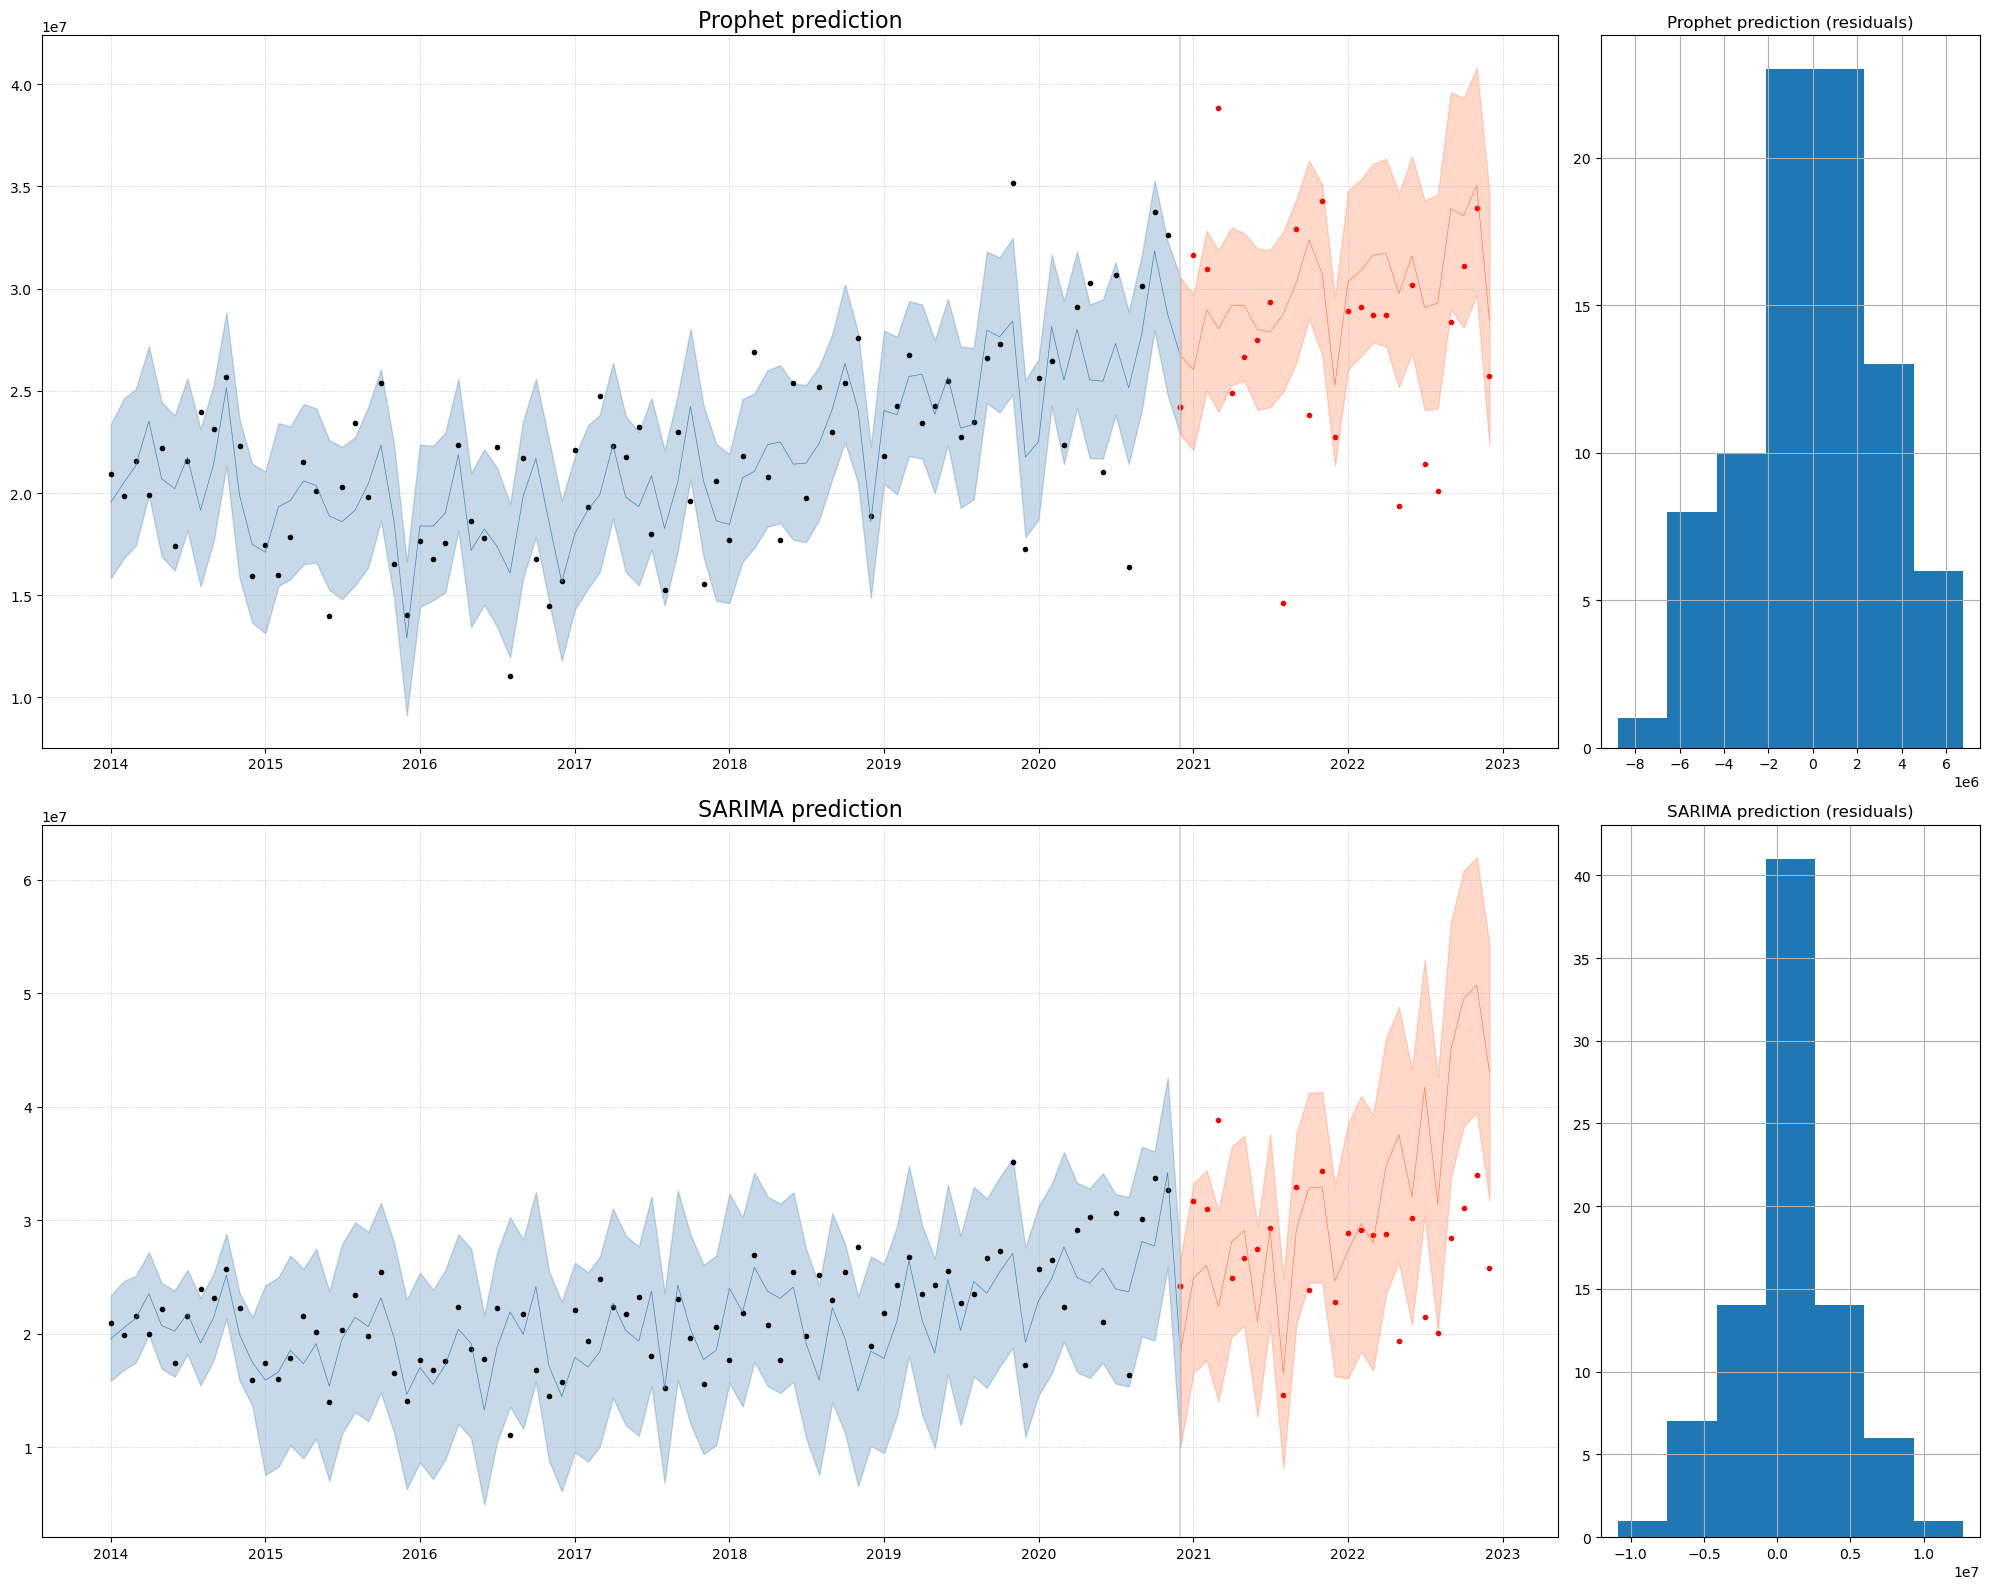

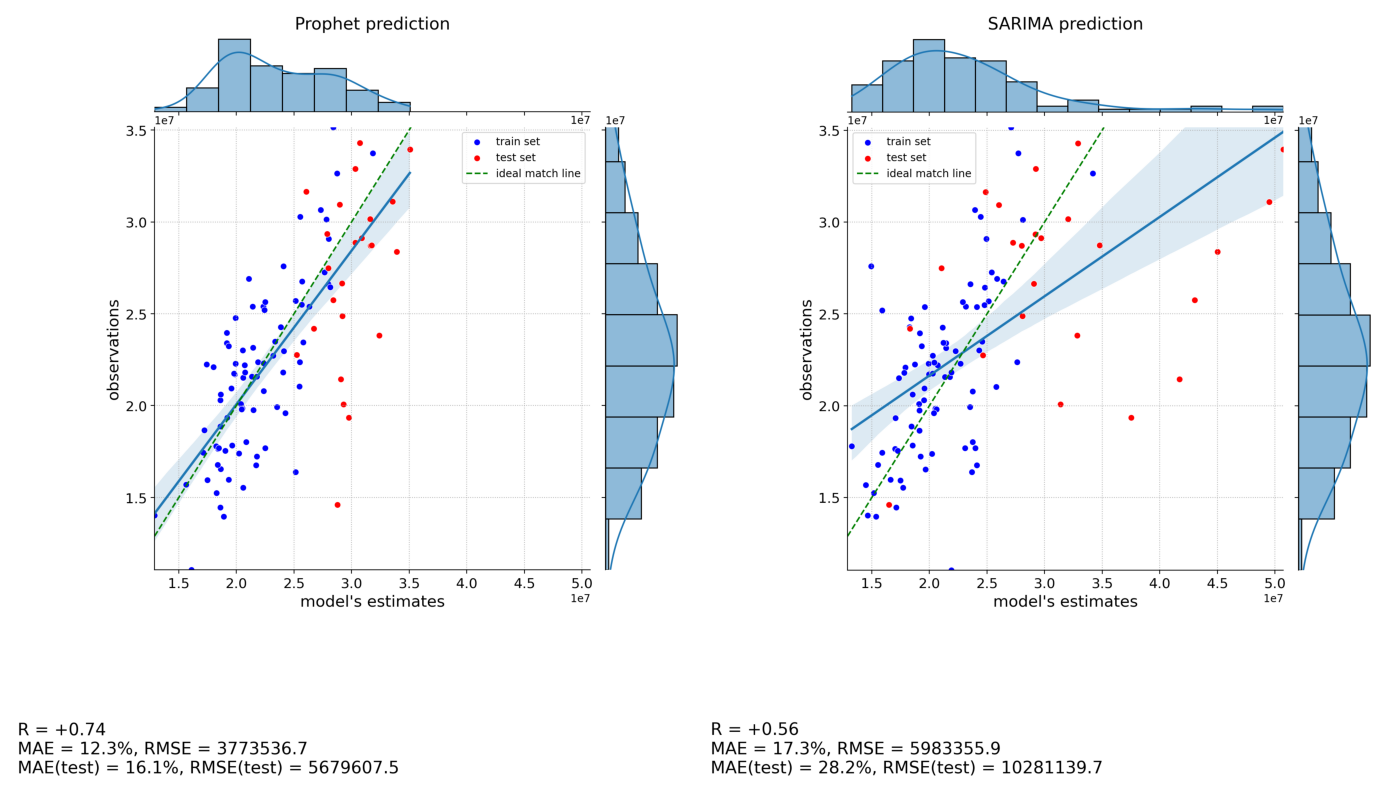

In [21]:
sarima_model = pickle.load(open('sarimax.model', 'rb'))
prophet_model = pickle.load(open('prof_cpi.model', 'rb'))

df_sales = pd.read_excel("data_for_clustering.xlsx", parse_dates=True,usecols = "A,B")
df_sales = df_sales.rename({
    "Sales_in_Cz" : "Sales"
}, axis='columns')
#string to date format
df_sales['Date'] = pd.to_datetime(df_sales['Date'],infer_datetime_format=True)
df_sales = df_sales.set_index(['Date'])
df_vaccines = pd.read_csv("vaccines.csv", parse_dates=True)

df_vaccines['Date'] = pd.to_datetime(df_vaccines['Date'], format='%Y-%m')
df_vaccines = df_vaccines.set_index('Date')

cpi_cz = [1.3, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.5, 0.5, 0.5, 0.4,
          0.3, 0.3, 0.3, 0.4, 0.4, 0.5, 0.5, 0.4, 0.4, 0.4, 0.3, 0.3,
          0.4, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.4, 0.5, 0.7,
          0.8, 1.0, 1.2, 1.3, 1.5, 1.7, 1.8, 2.0, 2.2, 2.3, 2.4, 2.5,
          2.4, 2.4, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.2, 2.2, 2.1,
          2.2, 2.3, 2.4, 2.4, 2.5, 2.5, 2.6, 2.6, 2.6, 2.7, 2.7, 2.8,
          2.9, 3.0, 3.1, 3.1, 3.1, 3.1, 3.2, 3.2, 3.3, 3.3, 3.2, 3.2,
          3.0, 2.9, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 3.0, 3.2, 3.5, 3.8,
          4.5, 5.2, 6.1, 7.0, 8.1, 9.4, 10.6, 11.7, 12.7, 13.5, 14.4, 15.1,
          15.7, 16.2]
data_cpi = {'Date': pd.date_range(start='2014-01-01', periods=len(cpi_cz), freq='MS'),
        'CPI': cpi_cz}

df_cpi = pd.DataFrame(data_cpi).set_index('Date')
df_cpi = df_cpi.loc[df_sales.index.min():df_sales.index.max(),:]
df_vaccines = df_vaccines.loc[df_sales.index.min():df_sales.index.max(),:]
df_external = pd.concat([df_cpi, df_vaccines], axis=1)

viz_df = make_df(prophet_model, sarima_model, df_sales, df_external, name='CPI')
plot_comparative(viz_df)


## Best prophet vs Best Sarima with Vaccine external

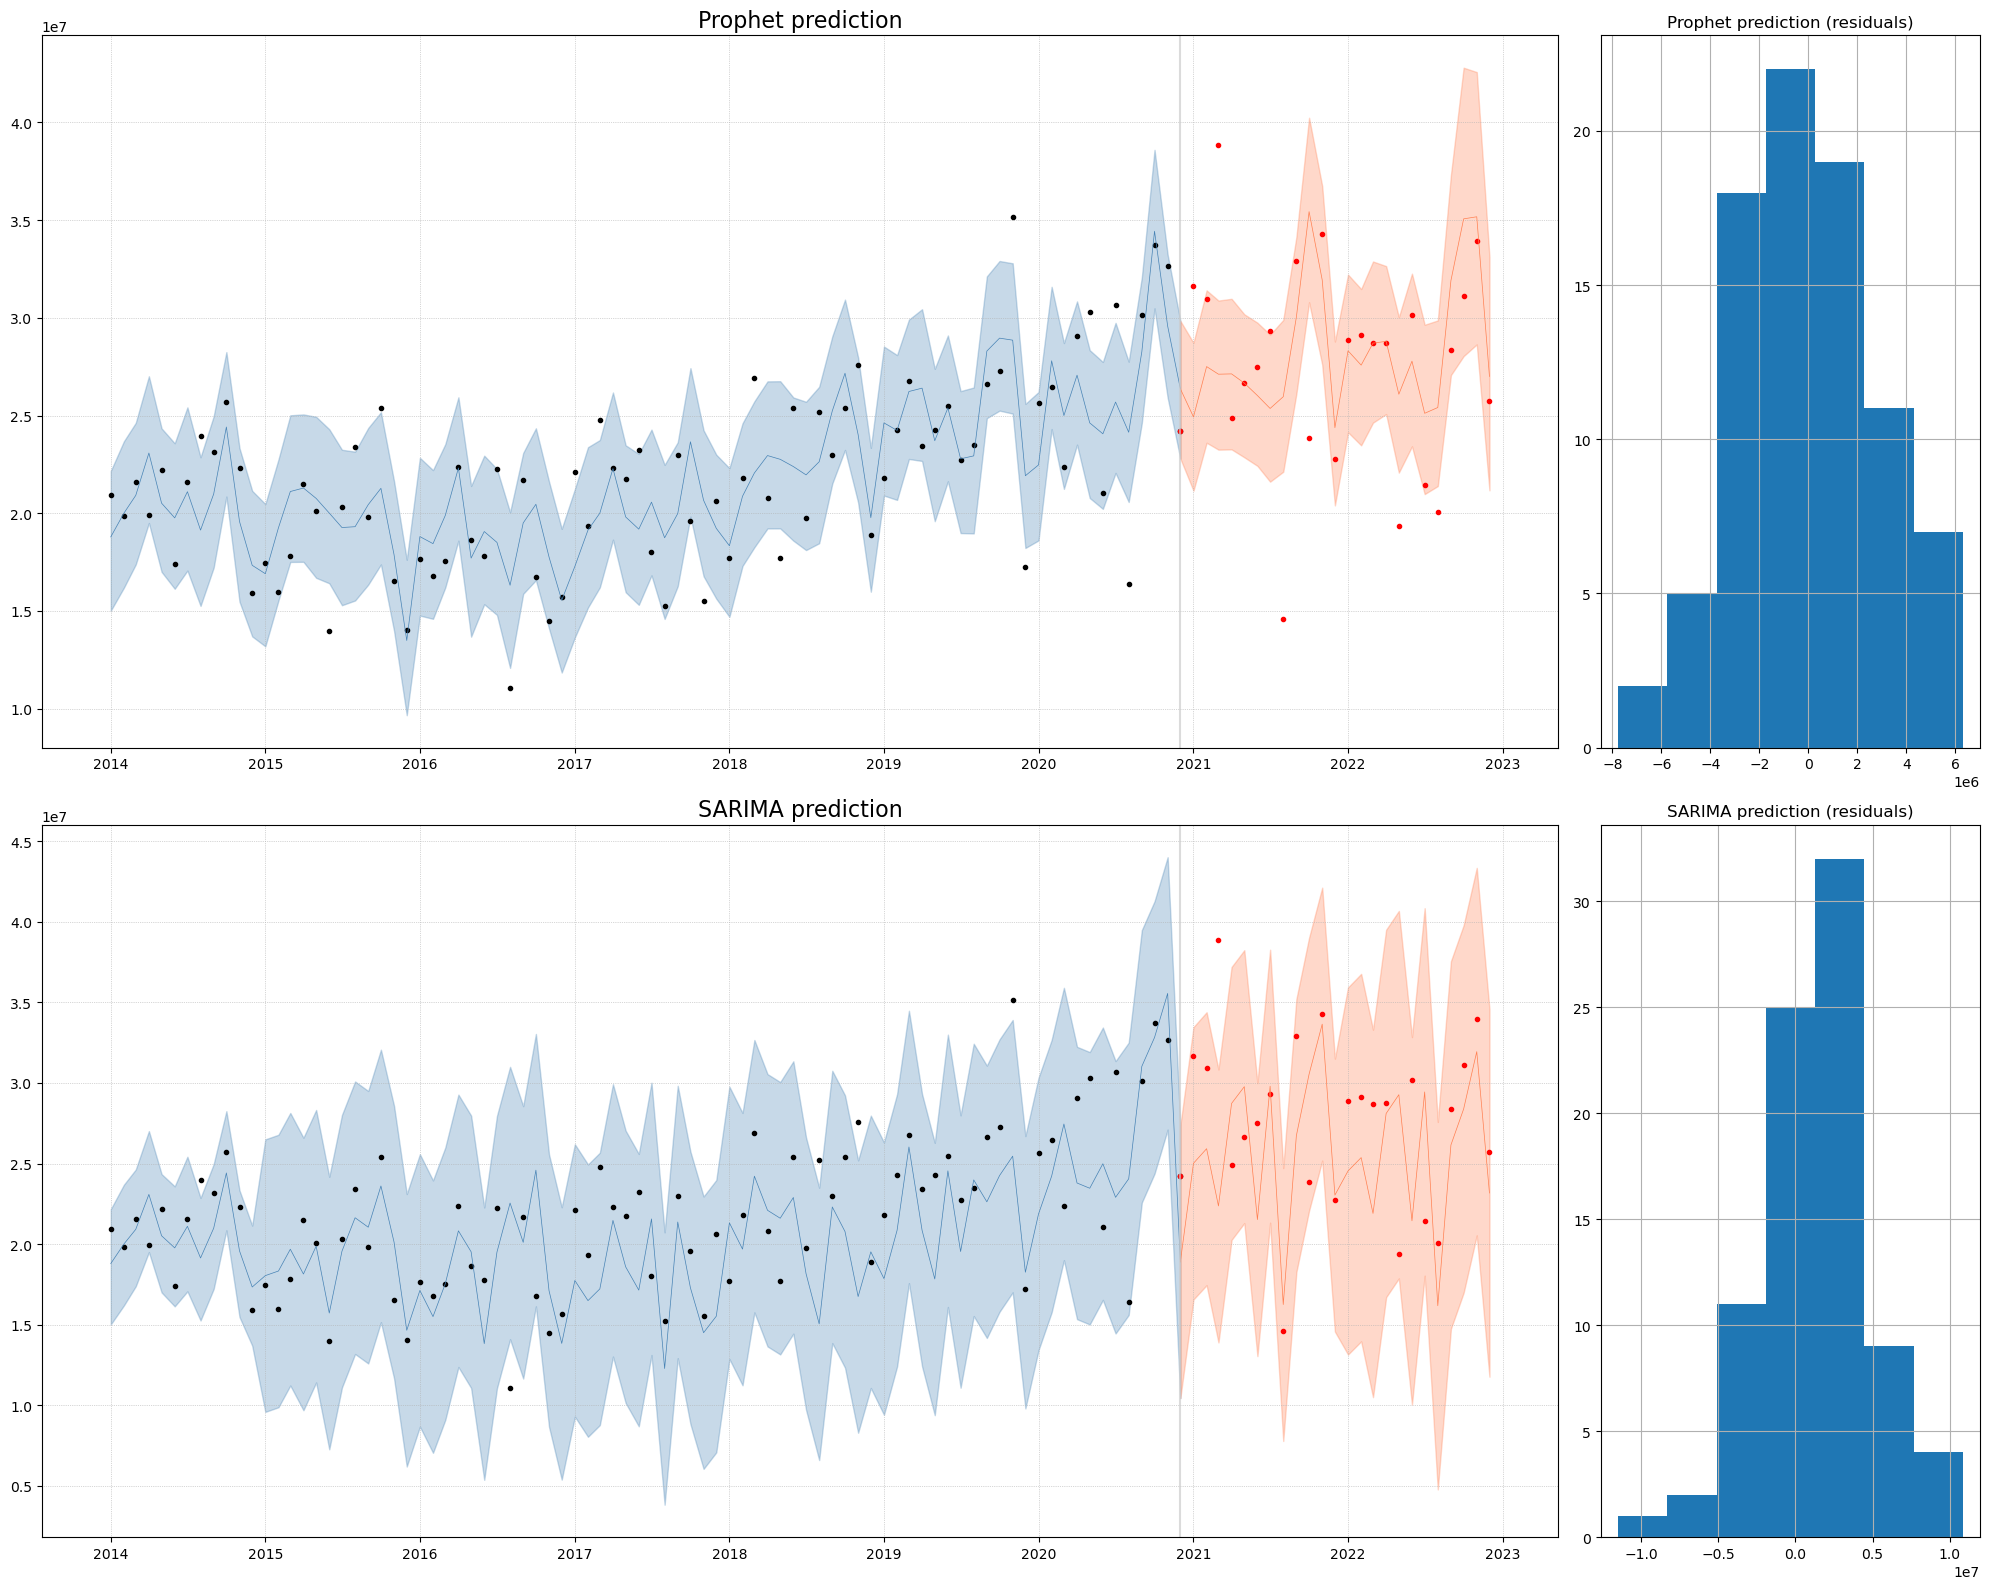

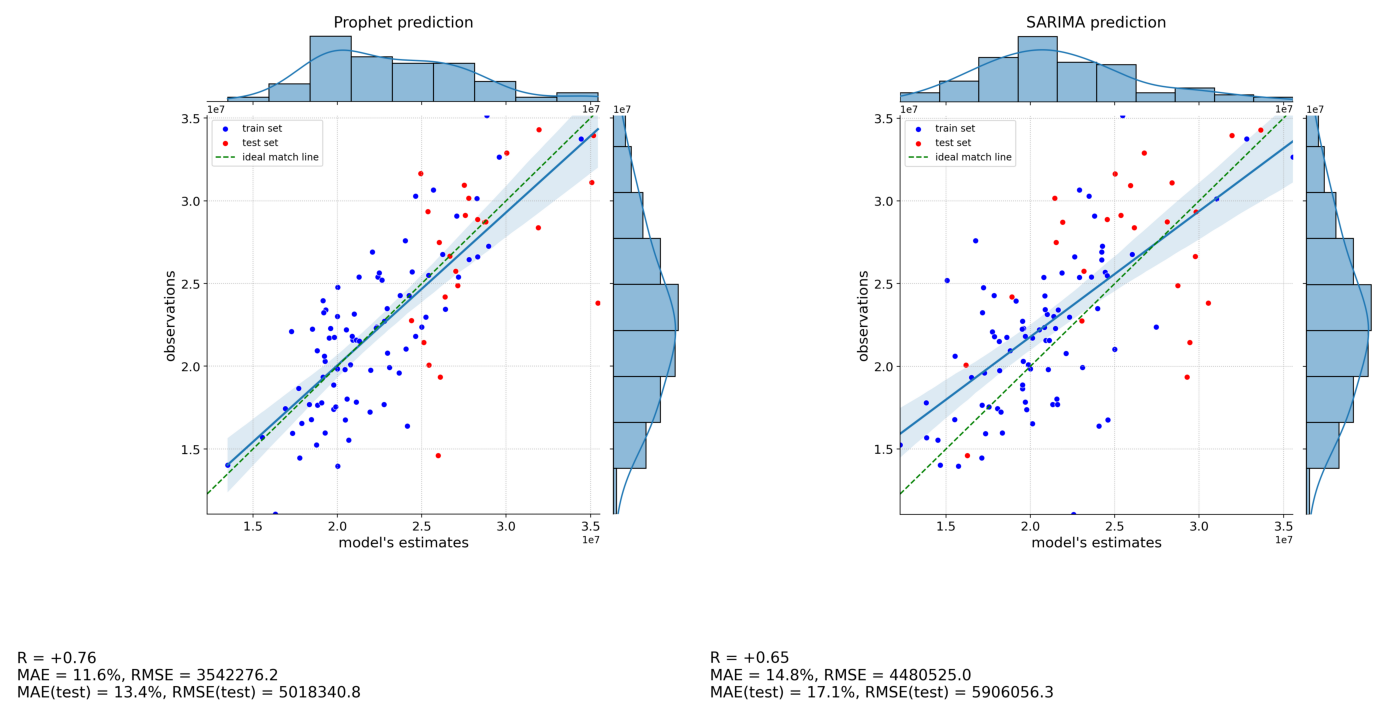

In [4]:
sarima_model = pickle.load(open('sarimax_vaccine.model', 'rb'))
prophet_model = pickle.load(open('prof.model', 'rb'))

df_sales = pd.read_excel("data_for_clustering.xlsx", parse_dates=True,usecols = "A,B")
df_sales = df_sales.rename({
    "Sales_in_Cz" : "Sales"
}, axis='columns')
#string to date format
df_sales['Date'] = pd.to_datetime(df_sales['Date'],infer_datetime_format=True)
df_sales = df_sales.set_index(['Date'])
df_vaccines = pd.read_csv("vaccines.csv", parse_dates=True)

df_vaccines['Date'] = pd.to_datetime(df_vaccines['Date'], format='%Y-%m')
df_vaccines = df_vaccines.set_index('Date')

cpi_cz = [1.3, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.5, 0.5, 0.5, 0.4,
          0.3, 0.3, 0.3, 0.4, 0.4, 0.5, 0.5, 0.4, 0.4, 0.4, 0.3, 0.3,
          0.4, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.4, 0.5, 0.7,
          0.8, 1.0, 1.2, 1.3, 1.5, 1.7, 1.8, 2.0, 2.2, 2.3, 2.4, 2.5,
          2.4, 2.4, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.2, 2.2, 2.1,
          2.2, 2.3, 2.4, 2.4, 2.5, 2.5, 2.6, 2.6, 2.6, 2.7, 2.7, 2.8,
          2.9, 3.0, 3.1, 3.1, 3.1, 3.1, 3.2, 3.2, 3.3, 3.3, 3.2, 3.2,
          3.0, 2.9, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 3.0, 3.2, 3.5, 3.8,
          4.5, 5.2, 6.1, 7.0, 8.1, 9.4, 10.6, 11.7, 12.7, 13.5, 14.4, 15.1,
          15.7, 16.2]
data_cpi = {'Date': pd.date_range(start='2014-01-01', periods=len(cpi_cz), freq='MS'),
        'CPI': cpi_cz}

df_cpi = pd.DataFrame(data_cpi).set_index('Date')
df_cpi = df_cpi.loc[df_sales.index.min():df_sales.index.max(),:]
df_vaccines = df_vaccines.loc[df_sales.index.min():df_sales.index.max(),:]
df_external = pd.concat([df_vaccines], axis=1)

viz_df = make_df(prophet_model, sarima_model, df_sales, df_external, name='vaccine')
plot_comparative(viz_df)
